### Клонируем git репозиторий ###


In [1]:
!git clone https://github.com/nkgrush/SSYP2022-ws8
%cd SSYP2022-ws8

Cloning into 'SSYP2022-ws8'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (30/30), done.
Checking out files: 100% (9/9), done.
/content/SSYP2022-ws8


### Загружаем и импортируем все необходимые модули ###

In [10]:
!pip install torchtext torchdata -q

import numpy as np
from functools import partial

from tqdm.notebook import tqdm, trange

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103

import random
from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm, trange
from torch.utils.data import random_split
import pandas as pd

import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Реализуем класс Dataset ###
В нем должны быть реализованы функции
- \_\_len\_\_(), возвоащающая количество данных
- \_\_getitem\_\_(), возвращающая одтн экземпляр данных, в формате [input, output]

In [5]:
class UniprotDataset(Dataset):
    def __init__(self, files):
        super().__init__()
        get_dataframe = lambda x: np.random.permutation(
           pd.read_csv(f"data/{x}.tsv", sep = '\t')['Sequence'].values
        )
        self.seq = []
        self.target = []
        for i in range(len(files)):
            data = get_dataframe(files[i])
            data = data[:10000]
            self.seq.append(data)
            self.target.extend([i] * len(data))
        self.seq = np.concatenate(self.seq)
        self.target = np.array(self.target)
        k = np.arange(len(self.seq))
        np.random.shuffle(k)
        self.seq = self.seq[k]
        self.target = self.target[k]
        self._len = len(self.target)

    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        return self.seq[index], self.target[index]

In [6]:
dataset = UniprotDataset('mammalia viridiplantae fungi viruses'.split())

### Реализуем класс BatchSampler ###
В нем должны быть реализованы функции
- \_\_len\_\_(), возвоащающая количество данных
- \_\_iter\_\_(), генератор, возвращающий индексы, которые войдут в следующий батч данных

In [7]:
class BatchSampler():
    def __init__(self, dataset, batch_size, tokenizer):
        lens = []
        self.idx = []
        self.batch_size = batch_size
        for x, y in dataset:
            x = tokenizer(x)
            lens.append(len(x))
        idx = np.arange(0, len(lens))

        for i in range(0, len(idx), batch_size * 100):
            sorted_idx = sorted(idx[i:i + batch_size * 100], key=lambda x: lens[x])
            self.idx.extend(sorted_idx)
        
        self.__len = len(idx) // batch_size

    def __len__(self):
        return self.__len

    def __iter__(self):
        batch_size = self.batch_size
        for batch_idx in range(0, self.__len):
            indices = self.idx[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            assert len(indices) == self.batch_size
            yield indices

### Создаем словарь и токенизатор ###
Словарь содержит все токены и сопоставляет им число \
Токенайзер в нашем случае - посимвольное разбиение текста

In [8]:
tokenizer = lambda x: list(x)
vocab = build_vocab_from_iterator(
        map(lambda seq_label: tokenizer(seq_label[0]), dataset),
        specials=["<unk>", "<pad>"],
    )
vocab.set_default_index(vocab["<unk>"])
PAD_IDX = vocab['<pad>']

### Создаем функцию, генерирующую батчи ###
Функция обрезает предложения до 200 токенов и дополняет все предложения в батче  
 до длины самого большого, чтобы модель могла параллельно обрабатывать весь батч

In [9]:
MAX_LEN = 200
def collate_fn(batch, text_pipeline=lambda x: vocab(tokenizer(x))):
    batch_input, batch_output = [], []
    for seq, target in batch:
        text_tokens_ids = text_pipeline(seq)[:MAX_LEN]
        batch_input.append(torch.tensor(text_tokens_ids, dtype=torch.long))
        batch_output.append(torch.tensor(target, dtype=torch.long))
    
    batch_input = pad_sequence(batch_input, padding_value=PAD_IDX)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.stack(batch_output)

    return batch_input, batch_output

### Разделяем dataset на тренировочную и тестовую выборку, создает DataLoader ###

In [13]:
print(len(dataset))

40000


In [14]:
train, test = random_split(dataset, [30000, 10000])

In [23]:
dtrain = DataLoader(train, collate_fn=collate_fn, batch_size = 128, shuffle = True)
dtest = DataLoader(test, collate_fn=collate_fn, batch_size = 128, shuffle = True)

### Создаем модель ###
Она состоит из:
- Embedding
- 2 слоя LSTM
- Линейный слой  
На выходе получится вектор размерности, равной количеству классов с вероятностями

In [52]:
class TaxonClassifier(nn.Module):
    def __init__(self, vocab_size, classes, input_dim, hid_dim, pad_idx):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_dim, hid_dim, num_layers=2, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, classes)
        self.softmax = nn.Softmax()    

    def forward(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.fc(x[0][-1])
        x = self.softmax(x)
        return x

Оптимизатор - Adam  
Функция потерь - Кросс-энтропия

In [42]:
model = TaxaonClassifier(len(vocab), 4, 300, 300, PAD_IDX)
optim = torch.optim.Adam(model.parameters(), lr=0.0045)
criterion = nn.CrossEntropyLoss()

### Цикл обучения ###

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, optim, criterion, dataloader, epochs = 5):
    model.train()
    model.to(device)
    history = []
    accuracy = []
    for e in trange(epochs):
        ep_loss = 0
        ep_acc = 0
        ep_total = 0
        i = 0
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            a = y_pred.argmax(-1)
            right = torch.sum(a==y)
            total = y.shape[0]
            loss.backward()
            optim.step()
            history.append(loss.cpu().item())
            accuracy.append((right / total).cpu().item())
            ep_loss += loss
            ep_acc += right
            ep_total += total
            i += 1

        print(f'Loss: {ep_loss/i}')
        print(f'Accuracy: {ep_acc/ep_total}')
    return history, accuracy

def test(model, criterion, dataloader):
    model.eval()
    model.to(device)
    history = []
    accuracy = []
    for e in trange(1):
        ep_loss = 0
        ep_acc = 0
        ep_total = 0
        i = 0
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            a = y_pred.argmax(-1)
            right = torch.sum(a==y)
            total = y.shape[0]
            history.append(loss.cpu().item())
            accuracy.append((right / total).cpu().item())
            ep_loss += loss
            ep_acc += right
            ep_total += total
            i += 1

        print(f'Loss: {ep_loss/i}')
        print(f'Accuracy: {ep_acc/ep_total}')
    return history, accuracy

### Обучение и проверка на тестовой выборке ###

In [44]:
lossTrain, accuracyTrain = train(model, optim, criterion, dtrain, 8)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Loss: 1.3593816757202148
Accuracy: 0.3234666585922241


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.277832269668579
Accuracy: 0.4403666853904724


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.2266086339950562
Accuracy: 0.49943333864212036


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.2119903564453125
Accuracy: 0.5191333293914795


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1880266666412354
Accuracy: 0.5425333380699158


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1688989400863647
Accuracy: 0.5659000277519226


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1573985815048218
Accuracy: 0.5760666728019714


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1381070613861084
Accuracy: 0.5976666808128357


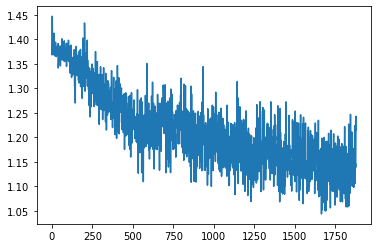

In [45]:
plt.plot(lossTrain)

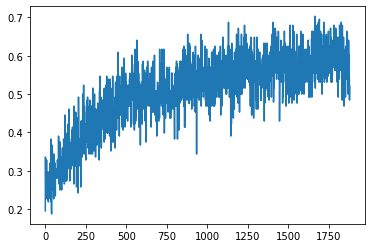

In [46]:
plt.plot(accuracyTrain)

In [49]:
lossTest, accuracyTest = test(model, criterion, dtest)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Loss: 1.1709873676300049
Accuracy: 0.5618999600410461


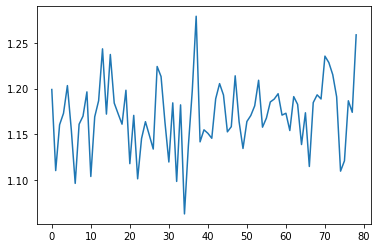

In [50]:
plt.plot(lossTest)

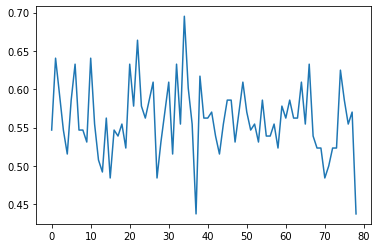

In [51]:
plt.plot(accuracyTest)